

## Topic Modeling - GutenBerg Books

#### Author: Kevin Okiah

**04/14/2019**

In this notebook, I explore Topic modeling using "Latent Dirichlet allocation" (LDA). LDA is a generative probabilistic model for collections of
discrete data such as text corpora. LDA is a three-level hierarchical Bayesian model,in which each item of a collection is modeled as a finite mixture over an underlying set of topics. Each topic is, in turn, modeled as an infinite mixture over an underlying set of topic probabilities. In the context of text modeling, the topic probabilities provide an explicit representation of a document. [Link](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)

#### Problem Statement
![](https://github.com/kevimwe/NaturalLanguageProcessing-NLP/blob/master/TopicModeling/topic_modeling.JPG)


#### NLP Pipeline Approach
I follow an NLP pipleine approach to find books similar to `The Flag of My Country. Shikéyah Bidah Na'at'a'í; Navajo New World Readers 2` from [Children's Instructional Books (Bookshelf)](https://www.gutenberg.org/wiki/Children%27s_Instructional_Books_(Bookshelf)) to recommend to my son as shown in the flow chart below.
![](https://github.com/kevimwe/NaturalLanguageProcessing-NLP/blob/master/TopicModeling/nlp_pipeline.JPG)

Data Collection and preprocessing were performed on separated notebooks which can be found in the `Notebooks` Directory
* **Data Acqusitions**  ->  /Notebooks/Scrape_GuternsbergBooks.ipynb
* **Pre-processing and EDA** -> /Notebooks/TextCleaning_and_EDA.ipynb

### Modeling

In [1]:
import os
from unipath import Path
import time
#visualization 
import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
%matplotlib inline

# Data Manipulation and Statistics
import pandas as pd
import numpy as np

#Directory Navigation and Saving instances
import os
from unipath import Path
wd = os.getcwd()
p = Path(wd)
path = str(p.parent)

#Text Cleaning and Analytics
import spacy
nlp = spacy.load('en_core_web_sm')

wd = os.getcwd()
p = Path(wd)
path = str(p.parent)


# Topic Modeling
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read data
data1 = pd.read_csv("Data/GuternsbergBooksClean.csv", encoding='utf-8')
#data1 = pd.read_csv("Data/MovieReviewsWithSentimentsClean.csv", encoding='utf-8')
data1.head(2)

,BookTitle,Category,url,Body,Corpus
0,"A Primary Reader: Old-time Stories, Fairy Tale...",Misc.,http://www.gutenberg.org/cache/epub/7841/pg784...,"['CONTENTS.', 'THE UGLY DUCKLING', 'THE LITTLE...","['ugly', 'duckling', 'little', 'pine', 'tree',..."
1,The Bird-Woman of the Lewis and Clark Expedition,Misc.,http://www.gutenberg.org/cache/epub/5742/pg574...,"['CONTENTS', 'THE BIRD-WOMAN', 'WHO THE WHITE ...","['bird', 'woman', 'white', 'men', 'sacajawea',..."


#### LDA -Latent Dirichlet Allocation

In [3]:
def VisualizeGridSearchResults(Data):
    '''
    display Log Likelihood Score comparison of different models
    
    '''
    plt.figure(figsize=(12, 7))
    ax = sns.pointplot(x="param_n_components", y="mean_test_score", hue="param_learning_decay",
                       data=Data, palette="Set2")
    plt.title("Choosing Optimal LDA Model")
    plt.xlabel("Num Topics")
    plt.ylabel("Log Likelyhood Scores")
    plt.legend(title='Learning decay', loc='best')

In [161]:
def OptimalTopicsGridSearch(Corpus=data1['Corpus'], NoOfTopics =[3,4,5,7,8,9, 10, 15, 25, 35, 40, 50],lda_=True, LearningDecay = [.3,.4, .5,.6,.7, .8],show =True):
        '''
        Function to run LDA Grid Search - LatentDirichletAllocation for topic modeling.
        *****************
        Inputs:
         - Corpus = Body of clean documents to identify topics
         - NoOfTopics = list of Number of topics for grid search
         - LearningDecay  = Learning Decay rate
         - show -  Flag to visualise grid searcg results
         - lda_  = Flag True to run LDA else false for NMF 
         '''
        #Define Search Param
        search_params = {'n_components': NoOfTopics, 'learning_decay': LearningDecay}
        
        if lda_ ==True:
            # Counter Vectorizer Object
            cv = CountVectorizer(max_df=0.90, min_df=5, stop_words='english') #max_df=0.95 (drop most frequent words) min_df=2 (drop unique words)

            # Init the Model
            model_ = LatentDirichletAllocation()
            
            #vectorize the data
            data_vectorized = cv.fit_transform(Corpus)
            GridSearchType =True
            
        else:
            #tfidf object
            cv = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
            data_vectorized = cv.fit_transform(Corpus)

            #NMF object
            model_ = NMF()
            GridSearchType =False
        
        if GridSearchType ==False:
            print("--------------------------------------------------")
            # RandomisedGridSearch 
            print("Performing Randomized Grid Search")
            print("--------------------------------------------------")
            start = time. time()
            model = RandomizedSearchCV(model_, param_distributions=search_params)

        else:
            #GridSearch
            print("Performing GridSearch")
            print("--------------------------------------------------")
            start = time. time()
            model = GridSearchCV(model_, param_grid=search_params)
        
        # Do the Grid Search
        model.fit(data_vectorized)

        print(model)
        # Best Model
        best_lda_model = model.best_estimator_
        print("--------------------------------------------------")
        # Model Parameters
        print("Best Model's Params: ", model.best_params_)

        # Log Likelihood Score
        print("Best Log Likelihood Score: ", model.best_score_)

        # Perplexity
        print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))
        end = time. time()
        print("--------------------------------------------------")
        print('Runtime :',end - start)
        GridResults = pd.DataFrame.from_dict(model.cv_results_)
        # Visualize gridSearch Results
        if show==True:
            VisualizeGridSearchResults(GridResults)
        return(GridResults)

GridResults = OptimalTopicsGridSearch(show=False, lda_=True)
# Saving Data for future analysis
GridResults.to_csv('Data/LDAGridResults.csv', header=True, index=False, encoding='utf-8')

Performing GridSearch
--------------------------------------------------
GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [3, 4, 5, 7, 8, 9, 10, 15, 25, 35, 40, 50], 'learning_decay': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
--------------------------------------------------
Best Model's Params:  {'learning_decay': 0.5, 'n_components': 4}
Best Log Likelihood Score:  

In [4]:
GridResults = pd.read_csv('Data/LDAGridResults.csv')

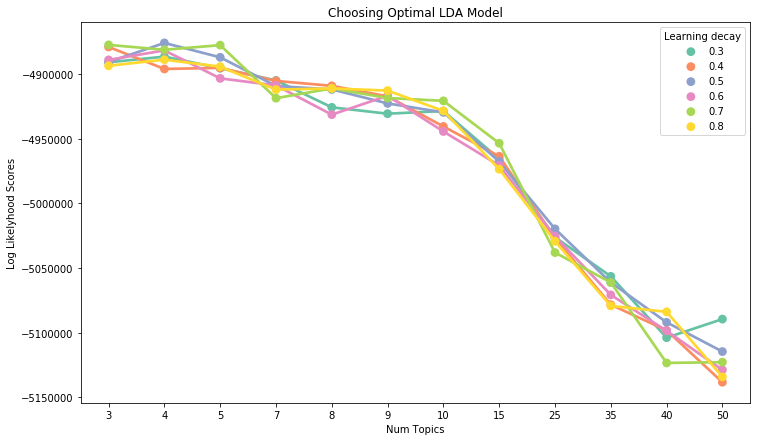

In [5]:
VisualizeGridSearchResults(GridResults)

In [58]:
def LatentDirichletAllocation_Run(Corpus=data1['Corpus'], NoOfTopics =4, TopWords = 15, show =False, LearningDecay = 0.5):
    '''
    Function to run LDA - LatentDirichletAllocation for topic modeling.
    *****************
    Inputs:
     - Corpus = Body of clean documents to identify topics
     - NoOfTopics = Number of topics
     - TopWords = Number of top words to display per topic
    ******************
    The function:
    1. Takes a Corpus and vectorizes it using Sklearn CountVectorizer
    2. Fits LDA on the data to identify topics
    3. Returns a dataframe with the corpus and topic assigned  
    
    '''
    Topic =pd.DataFrame()
    # Counter Vectorizer Object
    cv = CountVectorizer(max_df=0.90, min_df=5) #max_df=0.95 (drop most frequent words) min_df=2 (drop unique words)
   
    #vectorize the data
    dtm = cv.fit_transform(Corpus)
    print(dtm.shape)
    
    # Latent Dirichlet Allocation Model
    LDA = LatentDirichletAllocation(n_components=NoOfTopics,learning_decay=LearningDecay,random_state=100, max_iter=10)
    
    #lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True)
    #data_lda = lda.fit_transform(data_vectorized)
    
    TFIDF = TfidfVectorizer(max_df=0.90, min_df=4, stop_words='english')
    
    # This can take awhile, we're dealing with a large amount of documents!
    X_Topics =LDA.fit(dtm)
    #X_Topics =TFIDF.fit(dtm)
    
    # number of features /words
    print("-------------------------------------------------------")
    print("                   Topics Summary                      ")
    print("-------------------------------------------------------")
    print("Number of Features/Words :", len(cv.get_feature_names()))
    print("Number of Topics:", len(LDA.components_))
    print("-------------------------------------------------------")
    Words_topics = pd.DataFrame() #Sortd
    temp_topic =pd.DataFrame() #sorted
    WordCloud = pd.DataFrame()
    temp_wordcloud = pd.DataFrame()
    n= 0
    if( show ==True):
        for index,topic in enumerate(LDA.components_):
            print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
            print([cv.get_feature_names()[i] for i in topic.argsort()[-TopWords:]])
            # print([topic[i] for i in topic.argsort()[-TopWords:]])
            #Top_topics = Top_topics + [[cv.get_feature_names()[i] for i in topic.argsort()[-TopWords:]]]
            Sortedwords = [[cv.get_feature_names()[i] for i in topic.argsort()[-TopWords:]]]
            temp_topic["Topic"] = "Topic_"+str(n)
            temp_topic["Top5Words"] =list(Sortedwords)[0][0:15]
            temp_wordcloud["Topic"] = "Topic_"+str(n)
            temp_wordcloud["Words"] =list(Sortedwords)
            Words_topics = pd.concat([Words_topics, temp_topic], axis=0)
            WordCloud = pd.concat([WordCloud, temp_wordcloud], axis=0)
            WordCloud['Topic'] = WordCloud['Topic'].replace('nan', np.nan).fillna('Topic_0')
            Words_topics['Topic'] = Words_topics['Topic'].replace('nan', np.nan).fillna('Topic_0')
            print('\n')
            n =n+1
    topic_results = LDA.transform(dtm)
    
    # column names
    topicnames = ["Topic" + str(i) for i in range(NoOfTopics)]

    # index names
    docnames = ["Book" + str(i) for i in range(len(Corpus))]
    
    Topic=pd.DataFrame(topic_results)
    Topic = Topic.round(3) 
    Topic.columns=topicnames
    Topic.index=docnames
    Topic['Dominant_Topic'] = topic_results.argmax(axis=1) # Map topic to book
    Topic['Dominant_Topic'] = topic_results.argmax(axis=1) # Map topic to book
    
    return(Topic,LDA,cv, dtm, topic_results, Words_topics, WordCloud)

Temp_LDA, lda, vectorizer_cv, data_vectorized_cv ,LdaTR, WordsTopics, WordCloud= LatentDirichletAllocation_Run(NoOfTopics =4, show =True)
#data['Topic_by_LDA'] = list(Temp_LDA.Dominant_Topic)
data = data1.copy()
data.index=Temp_LDA.index
#data.index=Temp_LDA.BookTitle	
data = data.join(Temp_LDA)
data.head(2)

(104, 14453)
-------------------------------------------------------
                   Topics Summary                      
-------------------------------------------------------
Number of Features/Words : 14453
Number of Topics: 4
-------------------------------------------------------
THE TOP 15 WORDS FOR TOPIC #0
['make', 'bird', 'plant', 'come', 'insect', 'call', 'end', 'body', 'use', 'food', 'leave', 'form', 'small', 'animal', 'water']


THE TOP 15 WORDS FOR TOPIC #1
['qui', 'ce', 'des', 'se', 'el', 'il', 'du', 'un', 'les', 'que', 'et', 'en', 'le', 'la', 'de']


THE TOP 15 WORDS FOR TOPIC #2
['army', 'english', 'life', 'general', 'call', 'city', 'power', 'take', 'england', 'war', 'country', 'king', 'people', 'year', 'state']


THE TOP 15 WORDS FOR TOPIC #3
['word', 'father', 'life', 'let', 'leave', 'take', 'eye', 'shall', 'mother', 'hear', 'boy', 'think', 'tell', 'go', 'come']




,BookTitle,Category,url,Body,Corpus,Topic0,Topic1,Topic2,Topic3,Dominant_Topic
Book0,"A Primary Reader: Old-time Stories, Fairy Tale...",Misc.,http://www.gutenberg.org/cache/epub/7841/pg784...,"['CONTENTS.', 'THE UGLY DUCKLING', 'THE LITTLE...","['ugly', 'duckling', 'little', 'pine', 'tree',...",0.0,0.000,0.0,1.000,3
Book1,The Bird-Woman of the Lewis and Clark Expedition,Misc.,http://www.gutenberg.org/cache/epub/5742/pg574...,"['CONTENTS', 'THE BIRD-WOMAN', 'WHO THE WHITE ...","['bird', 'woman', 'white', 'men', 'sacajawea',...",0.2,0.014,0.0,0.786,3


In [59]:
# top words per topic
# Top 5 Keywords for each Topic
df_top5words_stacked = pd.DataFrame(WordsTopics, columns=['Topic', 'Top5Words'])
df_top5words = df_top5words_stacked.groupby('Topic').agg(', \n'.join)
df_top5words.reset_index(level=0,inplace=True)

In [60]:
df_top5words

,Topic,Top5Words
0,Topic_0,"make, \nbird, \nplant, \ncome, \ninsect, \ncal..."
1,Topic_1,"qui, \nce, \ndes, \nse, \nel, \nil, \ndu, \nun..."
2,Topic_2,"army, \nenglish, \nlife, \ngeneral, \ncall, \n..."
3,Topic_3,"word, \nfather, \nlife, \nlet, \nleave, \ntake..."


### Determining the topics based on top 15 words

In [61]:
Topic0 = list(WordsTopics[WordsTopics.Topic=='Topic_0']['Top5Words'])
Topic1 = list(WordsTopics[WordsTopics.Topic=='Topic_1']['Top5Words'])
Topic2 = list(WordsTopics[WordsTopics.Topic=='Topic_2']['Top5Words'])
Topic3 = list(WordsTopics[WordsTopics.Topic=='Topic_3']['Top5Words'])
#Topic4 = list(WordsTopics[WordsTopics.Topic=='Topic_4']['Top5Words'])

Summary = pd.DataFrame([Topic0, Topic1, Topic2, Topic3])
Summary.index = ['Topic_0','Topic_1', 'Topic_2', 'Topic_3'  ]
names = list(Summary.columns)
names_=[]
for i in names:
    names_=names_+['Word_'+str(names[i])]
Summary.columns = names_
Summary.T

,Topic_0,Topic_1,Topic_2,Topic_3
Word_0,make,qui,army,word
Word_1,bird,ce,english,father
Word_2,plant,des,life,life
Word_3,come,se,general,let
Word_4,insect,el,call,leave
Word_5,call,il,city,take
Word_6,end,du,power,eye
Word_7,body,un,take,shall
Word_8,use,les,england,mother
Word_9,food,que,war,hear


Based on the frequent words by topic above, we can deduce the topics as

>**Topic_0** - Science or Nature 

>**Topic_1** - Non English

>**Topic_2** - Geography, History, Civic

>**Topic_3** - General

### Visualizing  dominant Topic by probability.

In [62]:
from pandas.tools.plotting import table
cm = sns.light_palette("green", as_cmap=True)

s = Temp_LDA.style.background_gradient(cmap=cm, subset=['Topic0','Topic1','Topic2','Topic3', 'Topic4', 'Topic5', 'Topic6'])
print("LDA Topics Book Assignment Heatmap");
s.to_excel('a.xlsx', engine='openpyxl')
s

LDA Topics Book Assignment Heatmap


,Topic0,Topic1,Topic2,Topic3,Dominant_Topic
Book0,0,0,0,1,3
Book1,0.2,0.014,0,0.786,3
Book2,0.119,0,0.44,0.441,3
Book3,0.008,0,0,0.992,3
Book4,0,0,0,1,3
Book5,0,0,0,1,3
Book6,0.531,0.01,0.266,0.194,0
Book7,0.444,0,0,0.556,3
Book8,0.04,0,0.05,0.91,3
Book9,0.015,0.013,0,0.972,3


,Topic Num,Num Documents
0,3,55
1,0,32
2,2,11
3,1,6


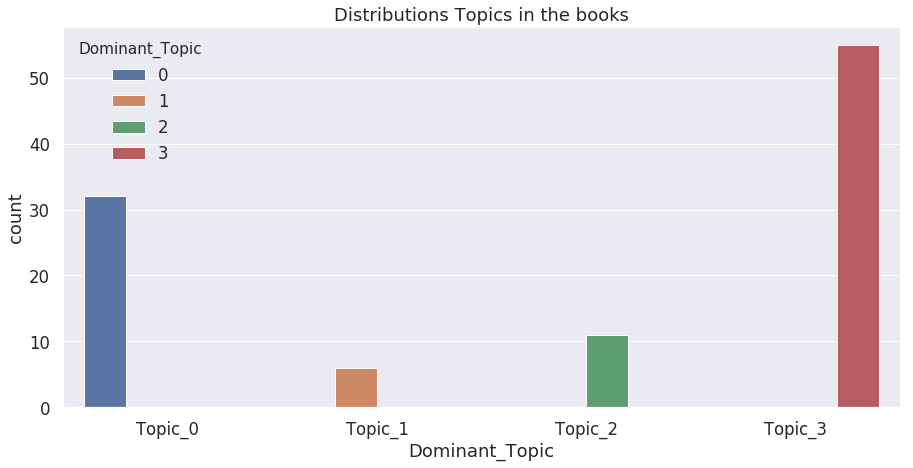

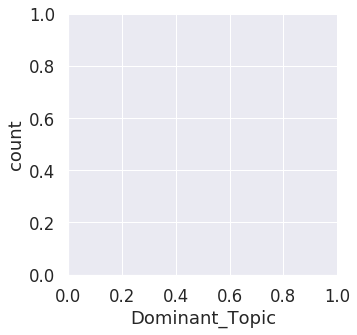

In [63]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(15,7))
sns.set_style("darkgrid")
g=sns.catplot(hue='Dominant_Topic', x='Dominant_Topic',
                 data=data, kind="count",ax=ax);
#ax.set_xticklabels(rotation=90)
ax.set_xticklabels(df_top5words.Topic)#+'\n'+df_top5words.Top5Words);
ax.set_title(r'Distributions Topics in the books')

Topic_Distribution = data['Dominant_Topic'].value_counts().reset_index(name="Num Documents")
Topic_Distribution.columns = ['Topic Num', 'Num Documents']
Topic_Distribution


### Visualizing LDA  Results with pyLDAvis

In [64]:
pyLDAvis.enable_notebook()
dash2 = pyLDAvis.sklearn.prepare(lda, data_vectorized_cv, vectorizer_cv, mds='tsne')
dash2

PreparedData(topic_coordinates=            Freq  cluster  topics          x           y
topic                                                   
3      45.832753        1       1 -22.189211 -265.243439
0      26.144345        1       2  34.612003 -151.636261
2      22.555055        1       3  63.015480 -236.840775
1       5.467847        1       4 -50.592365 -180.039490, topic_info=      Category          Freq   Term         Total  loglift  logprob
term                                                               
3138   Default  10103.000000     de  10103.000000  30.0000  30.0000
7149   Default   7896.000000     la   7896.000000  29.0000  29.0000
7278   Default   3926.000000     le   3926.000000  28.0000  28.0000
4139   Default   3551.000000     en   3551.000000  27.0000  27.0000
4330   Default   2775.000000     et   2775.000000  26.0000  26.0000
10116  Default   2575.000000    que   2575.000000  25.0000  25.0000
7356   Default   2209.000000    les   2209.000000  24.0000  24.0000
13305  Default   2012.000000     un   2012.000000  23.0000  23.0000
3871   Default   1957.000000     du   1957.000000  22.0000  22.0000
6341   Default   1820.000000     il   1820.000000  21.0000  21.0000
11144  Default   1559.000000     se   1559.000000  20.0000  20.0000
4034   Default   1554.000000     el   1554.000000  19.0000  19.0000
3341   Default   1436.000000    des   1436.000000  18.0000  18.0000
11806  Default   2200.000000    son   2200.000000  17.0000  17.0000
1909   Default   1263.000000     ce   1263.000000  16.0000  16.0000
10131  Default   1246.000000    qui   1246.000000  15.0000  15.0000
4321   Default   1154.000000    est   1154.000000  14.0000  14.0000
3079   Default   1108.000000    dan   1108.000000  13.0000  13.0000
9698   Default   1262.000000   pour   1262.000000  12.0000  12.0000
784    Default   1073.000000     au   1073.000000  11.0000  11.0000
9064   Default   1007.000000    par   1007.000000  10.0000  10.0000
11547  Default   1662.000000   sing   1662.000000   9.0000   9.0000
12461  Default    946.000000    sur    946.000000   8.0000   8.0000
9562   Default    946.000000   plus    946.000000   7.0000   7.0000
300    Default    931.000000     al    931.000000   6.0000   6.0000
8662   Default    886.000000   nous    886.000000   5.0000   5.0000
3437   Default    882.000000     di    882.000000   4.0000   4.0000
9579   Default   2204.000000  point   2204.000000   3.0000   3.0000
11475  Default    835.000000     si    835.000000   2.0000   2.0000
13964  Default   4947.000000  water   4947.000000   1.0000   1.0000
...        ...           ...    ...           ...      ...      ...
10131   Topic4   1239.967673    qui   1246.268748   2.9012  -4.3497
784     Topic4   1068.169381     au   1073.635537   2.9012  -4.4988
9800    Topic4    267.737005   pret    269.112754   2.9012  -5.8825
6521    Topic4    471.992329    ind    475.554116   2.8988  -5.3155
10885   Topic4    620.141779     sa    625.127979   2.8983  -5.0426
9638    Topic4    306.836801    por    309.691625   2.8970  -5.7462
1858    Topic4    130.860888   casa    132.170418   2.8963  -6.5984
5249    Topic4    155.645634    fut    157.258819   2.8960  -6.4249
4034    Topic4   1537.644010     el   1554.210616   2.8956  -4.1345
8461    Topic4    747.355037     ne    756.457884   2.8942  -4.8560
4769    Topic4     60.963285    fil     61.744173   2.8936  -7.3622
3079    Topic4   1094.406196    dan   1108.561201   2.8934  -4.4745
13860   Topic4    158.044593   vous    160.173668   2.8929  -6.4096
7278    Topic4   3873.591779     le   3926.665919   2.8927  -3.2106
7226    Topic4    330.116890    las    334.773578   2.8923  -5.6731
7149    Topic4   7784.045511     la   7896.613189   2.8919  -2.5127
4139    Topic4   3495.836134     en   3551.436848   2.8905  -3.3132
11144   Topic4   1537.577893     se   1559.430729   2.8922  -4.1345
3871    Topic4   1921.934278     du   1957.713125   2.8878  -3.9114
3341    Topic4   1411.070143    des   1436.828832   2.8882  -4.2204
9562    Top

## Clustering

In [65]:
lda_output = LdaTR

In [79]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
import sklearn.cluster as cluster
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA as sklearnPCA

from sklearn.decomposition import FactorAnalysis


from scipy.spatial.distance import cdist
from yellowbrick.cluster import KElbowVisualizer
import hdbscan
#import plotly_express as px
%matplotlib inline
#.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}


sklearn_pca = sklearnPCA(n_components=2)
#Lda_PCA = FactorAnalysis(n_components = 2).fit_transform(Temp_LDA)

Lda_PCA = sklearn_pca.fit_transform(Temp_LDA)

In [80]:
# diplay clustering results
#https://github.com/scikit-learn-contrib/hdbscan/blob/master/notebooks/Comparing%20Clustering%20Algorithms.ipynb
def plot_clusters(data,n_clusters, algorithm, args, kwds, n, show_labels =False):
    '''
    Function to cluster data and plot them
    
    n = real labels from the dataset to display
    show_label = flag to display original data labels if any
    algorithm = takes any algorithm supported by sklearn
    
    '''
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('bright', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    fig, ax = plt.subplots(figsize=(20,15))
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    #px.scatter(data.T, data.T[0], data.T[1])

    z = data.T[0]
    y = data.T[1]
    # label the points
    if show_labels:
        for i, txt in enumerate(n):
            ax.annotate(txt, (z[i], y[i]))
        
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title(str(n_clusters) +' Clusters found by {}'.format(str(algorithm.__name__)), fontsize=14)
    #plt.text(-0.3, 0.4, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    return(labels)


#https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster
from sklearn.metrics import silhouette_samples, silhouette_score
#plot_clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':15})

AlgosDict ={"Kmean":cluster.KMeans,
            #"MiniBatch":cluster.MiniBatchKMeans,
            #"Spectral":cluster.SpectralClustering,
            #"Agglomerative":cluster.AgglomerativeClustering,
            #"MeanShift":cluster.MeanShift,
            #"AffinityProgation":cluster.AffinityPropagation,
            #"hdbscan":hdbscan.HDBSCAN            
           }

def run_Clustering_Algo(n_clusters = [4], Algos_Dict = AlgosDict, data =Lda_PCA, showlabels =True, flag = True, ClusterLabels = data.Dominant_Topic):
    """
    Function to run multiple clustering algos and plot results
    Setup for clustering Algos that require number of clusters to be specified
    Stores clustering labels
    flag =True (run algos that don't required cluster size)
    """
    temp = pd.DataFrame()
    temp["PCA1"] = data.T[0]
    temp["PCA2"] = data.T[1]
    Silhoute_scores = pd.DataFrame()
    for i in n_clusters:
        for key, value in Algos_Dict.items():
            if (key!="AffinityProgation") and (key!="MeanShift") and (key!="hdbscan"):
                labels = plot_clusters(data,i, value, (), {'n_clusters':i}, 
                                      n = ClusterLabels, show_labels=showlabels)
                temp[key+"_"+str(i)] = labels
                print("# of Clusters for " + key +" " + str(len(np.unique(labels)))) 
                silhouette_avg = silhouette_score(data, labels)
                print("#Avg silhouette "+ str(silhouette_avg))
                Silhoute_scores[key+"_"+str(i)] = silhouette_avg
                print("---------------------------------------")
                # Compute the silhouette scores for each sample
                sample_silhouette_values = silhouette_samples(data, labels)
            else:
                if flag:
                    labels = plot_clusters(data,i, value, (), {}, 
                                           n = ClusterLabels, show_labels=showlabels)
                    temp[key] = labels
                    print("# of Clusters for " + key +" " + str(len(np.unique(labels)))) 
                    
        
    return(temp, sample_silhouette_values)
    
#ClusterLabels, Silhoute_scores = run_Clustering_Algo()

# of Clusters for Kmean 4
#Avg silhouette 0.8271313582982562
---------------------------------------


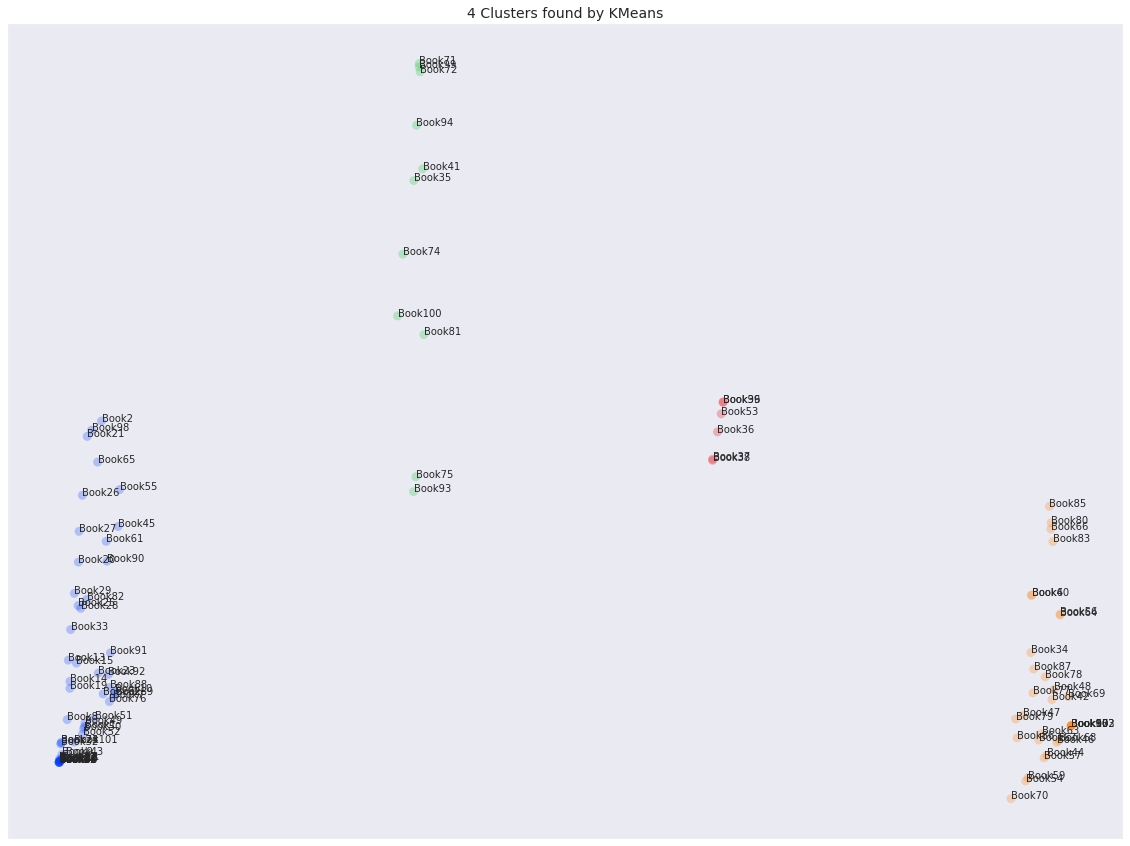

In [81]:
ClusterLabels, Silhoute_scores = run_Clustering_Algo(ClusterLabels = data.index)

### Conclusion

Books in the science category similar the `The Flag of My Country. Shikéyah Bidah Na'at'a'í; Navajo New World Readers 2`

In [73]:
data.head()

,BookTitle,Category,url,Body,Corpus,Topic0,Topic1,Topic2,Topic3,Dominant_Topic
Book0,"A Primary Reader: Old-time Stories, Fairy Tale...",Misc.,http://www.gutenberg.org/cache/epub/7841/pg784...,"['CONTENTS.', 'THE UGLY DUCKLING', 'THE LITTLE...","['ugly', 'duckling', 'little', 'pine', 'tree',...",0.000,0.000,0.00,1.000,3
Book1,The Bird-Woman of the Lewis and Clark Expedition,Misc.,http://www.gutenberg.org/cache/epub/5742/pg574...,"['CONTENTS', 'THE BIRD-WOMAN', 'WHO THE WHITE ...","['bird', 'woman', 'white', 'men', 'sacajawea',...",0.200,0.014,0.00,0.786,3
Book2,"Dr. Scudder's Tales for Little Readers, About ...",Misc.,http://www.gutenberg.org/cache/epub/13539/pg13...,"['CONTENTS.', 'CHAPTER I.', 'General Remarks',...","['chapter', 'general', 'remarks', 'chapter', '...",0.119,0.000,0.44,0.441,3
Book3,The Louisa Alcott Reader: a Supplementary Read...,Misc.,http://www.gutenberg.org/cache/epub/7425/pg742...,"['CONTENTS.', 'I. A CHRISTMAS DREAM', 'II. THE...","['christmas', 'dream', 'ii', 'candy', 'country...",0.008,0.000,0.00,0.992,3
Book4,"Boy Blue and his friends, School ed.",Misc.,http://www.gutenberg.org/cache/epub/16046/pg16...,"['~CONTENTS~', 'LITTLE BOY BLUE', 'SNOWBALL', ...","['little', 'boy', 'blue', 'snowball', 'fire', ...",0.000,0.000,0.00,1.000,3


In [74]:
# filter to topic 0
cols = ['BookTitle','Category', 'Topic0','Topic1','Topic2','Topic3','Dominant_Topic']

Final = data[cols]
Final = Final[Final.Dominant_Topic.isin([data.loc['Book6'].Dominant_Topic])] #books similar to Book 6

In [77]:
Final

,BookTitle,Category,Topic0,Topic1,Topic2,Topic3,Dominant_Topic
Book6,The Flag of My Country. Shikéyah Bidah Na'at'a...,Misc.,0.531,0.010,0.266,0.194,0
Book34,Gems of Poetry for Boys and Girls,Poetry Readers,0.573,0.000,0.185,0.242,0
Book40,The Flag of My Country. Shikéyah Bidah Na'at'a...,Non-English Readers,0.531,0.010,0.266,0.194,0
Book42,A Book of Natural HistoryYoung Folks' Library ...,Science and Nature,0.803,0.000,0.075,0.122,0
Book44,Wildflowers of the Farm,Science and Nature,0.799,0.000,0.000,0.201,0
Book46,Book about Animals,Science and Nature,0.879,0.001,0.001,0.119,0
Book47,Bird Day; How to prepare for it,Science and Nature,0.548,0.000,0.104,0.347,0
Book48,Child's Book of Water Birds,Science and Nature,0.811,0.001,0.086,0.101,0
Book54,The Burgess Animal Book for Children,Science and Nature,0.626,0.000,0.000,0.374,0
Book56,The History of Insects,Science and Nature,0.810,0.000,0.190,0.000,0


In [78]:
%load_ext version_information
%version_information pandas, numpy, requests, bs4, selenium, lxml, urllib3, pyvirtualdisplay, unipath

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software,Version
Python,3.6.8 64bit [GCC 7.3.0]
IPython,7.2.0
OS,Linux 4.15.0 46 generic x86_64 with debian buster sid
pandas,0.22.0
numpy,1.16.2
requests,2.21.0
bs4,4.7.1
selenium,3.141.0
lxml,4.3.2
urllib3,1.24.1



Refernces
* https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/